# Power Generation in the UK 

## Data Prep

Analyze daily power generation by source.

In [2]:
# Import packages for data vizualisation
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Insert Data Source Here

from domino.data_sources import DataSourceClient

# instantiate a client and fetch the datasource instance
object_store = DataSourceClient().get_datasource("domino-power-generation-workshop")

# list objects available in the datasource
objects = object_store.list_objects()

## get content as binary
# content = object_store.get("key")

## download content to file
# object_store.download_file("key", "./path/to/local/file")

## Download content to file object
# f = io.BytesIO()
# object_store.download_fileobj("key", f)

In [4]:
from io import StringIO
import pandas as pd

s = str(object_store.get("PowerGenerationData_June2022.csv"),'utf-8')
data = StringIO(s) 

df = pd.read_csv(data)
df.head()

,HDF,datetime,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTEM
0,FUELHH,2022-06-01 00:00:00,16925,0,0,5139,1445,0,257,2,155,8,178,0,0,1718,0
1,FUELHH,2022-06-01 00:30:00,16539,0,0,5140,1432,0,234,3,149,0,200,0,0,1701,0
2,FUELHH,2022-06-01 01:00:00,17381,0,0,5142,1566,0,201,0,124,0,170,0,0,1698,0
3,FUELHH,2022-06-01 01:30:00,17415,0,0,5137,1491,0,197,0,139,0,168,0,0,1720,0
4,FUELHH,2022-06-01 02:00:00,17457,0,0,5137,1337,0,196,0,152,0,188,0,0,1734,0


## Vizualize the static dataset using matplotlib
There are many fuel types in the dataset. To improve vizualization, we will only select the following columns, and group the minor fuel sources togetehr into "Other".

Fuel Sources:  
CCGT - Combined Cycle Gas Turbines (natural gas)  
Wind  
Nuclear  
Biomass  
Coal

<Figure size 864x864 with 0 Axes>

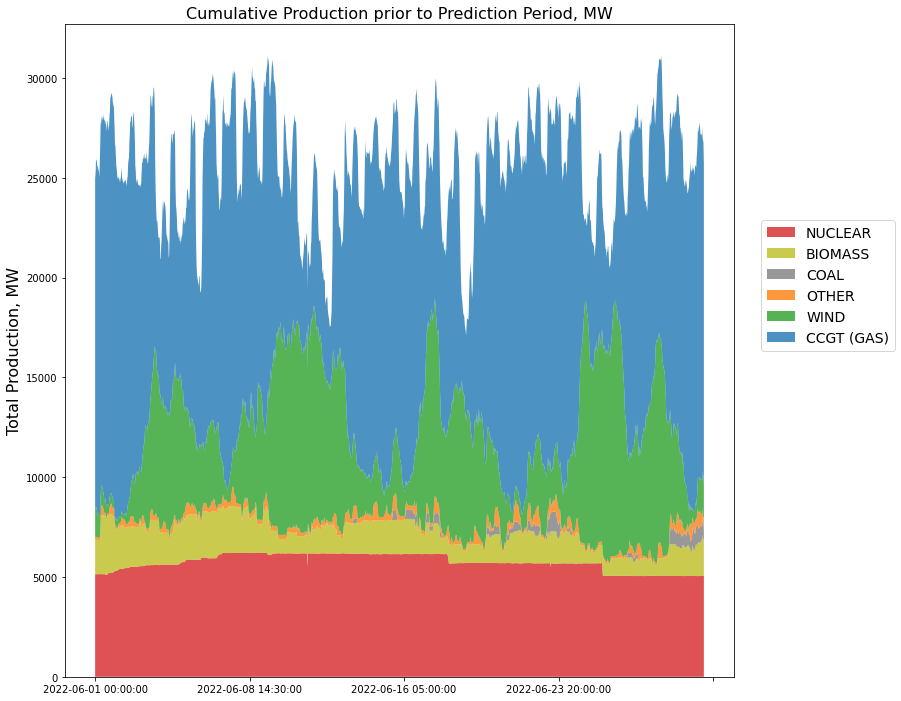

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.dates as mdates

# Create total output feature: sum of all fuel sources.
df['TOTAL'] = df.sum(axis=1, numeric_only=True)

# Select CCGT, Wind, Nuclear, Biomass and Coal
plot_cols = ['CCGT', 'WIND', 'NUCLEAR','BIOMASS', 'COAL', 'TOTAL']

df_plot = df[plot_cols].copy()

df_plot['OTHER'] = df_plot['TOTAL'] - df_plot[['CCGT', 'WIND', 'NUCLEAR','BIOMASS', 'COAL']].sum(axis=1, numeric_only=True)

# Plot Cumulative production up to prediction point

plt.figure(figsize=(12,12))

colors = ['tab:red','tab:olive', 'tab:gray','tab:orange','tab:green','tab:blue']

x = df.datetime
y = [df.NUCLEAR, df.BIOMASS, df.COAL, df.OTHER, df.WIND, df.CCGT,]

fig, ax = plt.subplots(1,1, figsize=(12,12))

ax.stackplot(x,y,
              labels=['NUCLEAR', 'BIOMASS', 'COAL', 'OTHER', 'WIND', 'CCGT (GAS)'],
              colors=colors,
             alpha=0.8)
ax.legend(bbox_to_anchor=(1.25, 0.6), loc='right', fontsize=14)
days = mdates.DayLocator()
months = mdates.MonthLocator()
years = mdates.YearLocator()
ax.xaxis.set_major_locator(years)

ax.set_ylabel('Total Production, MW', fontsize=16)
ax.set_title('Cumulative Production prior to Prediction Period, MW', fontsize=16)

plt.show()

# Save the figure as an image to the Domino File System
plt.savefig('Cumulative Production.png')

In [ ]:
df.head()